In [2]:
import csv
from collections import Counter
from constants import SEEDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_predict

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
SEED = SEEDS[3]

albums = pd.read_csv(f'./embeddings/albums_embeddings_sdne_[512, 128]_150_{SEED}.csv', index_col='id', quoting=csv.QUOTE_ALL)
albums.embedding = albums.embedding.apply(lambda embedding: np.fromstring(embedding[1:-1], dtype=np.float32, sep=' '))

# Visualization

In [4]:
pca = PCA(n_components=2, random_state=SEED)
principal_components = pca.fit_transform(np.array(albums.embedding.tolist()))

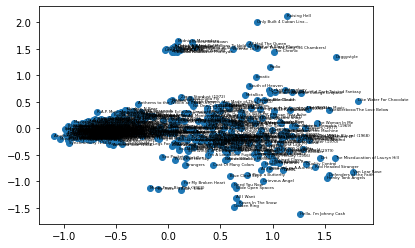

In [5]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])

for index, row in albums.iterrows():
    plt.annotate(row.title, (principal_components[index, 0], principal_components[index, 1]), fontsize=4)

plt.show()

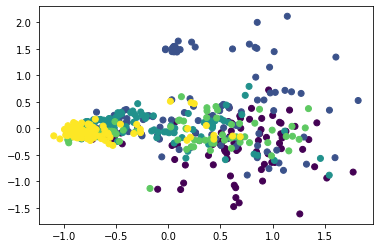

In [6]:
albums_labels = {label:index for index, label in enumerate(albums.label.unique())}
albums_colours = albums.label.map(albums_labels)

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=albums_colours)
plt.show()

# Similarity

In [7]:
cos_similarity = cosine_similarity(np.array(albums.embedding.tolist()), np.array(albums.embedding.tolist()))

In [8]:
albums_index = 295
print(albums.iloc[albums_index].title)

closest_albums = cos_similarity[albums_index].argsort()[-6:][::-1]
for closest_album in closest_albums[1:]:
    print(albums.iloc[closest_album].title, cos_similarity[albums_index, closest_album])

Blood On the Tracks (1975)
Bringing It All Back Home (1965) 0.9755772
Highway 61 Revisited (1965) 0.97007555
Blonde On Blonde (1966) 0.96601295
I Don’t Like Shit, I Don’t Go Outside 0.9525491
The Wall (1979) 0.9497513


# Classification

In [9]:
classification_result = {'accuracy': 0}
for label in albums.label.unique():
    classification_result[label] = {}

for SEED in SEEDS:
    albums = pd.read_csv(f'./embeddings/albums_embeddings_sdne_[512, 128]_150_{SEED}.csv', index_col='id', quoting=csv.QUOTE_ALL)
    albums.embedding = albums.embedding.apply(lambda embedding: np.fromstring(embedding[1:-1], dtype=np.float32, sep=' '))
    
    X = np.array(albums.embedding.tolist())
    y = albums_colours.to_numpy()
    
    logistic_classifier = LogisticRegression(multi_class='ovr', random_state=SEED)
    predicted = cross_val_predict(logistic_classifier, X, y, cv=10)
    
    class_report = classification_report(y, predicted, target_names=albums.label.unique(), output_dict=True)
    classification_result['accuracy'] += class_report['accuracy']
    
    if SEED is SEEDS[0]:
        for label in albums.label.unique():
            classification_result[label] = Counter(class_report[label])
    else:
        for label in albums.label.unique():
            classification_result[label] += Counter(class_report[label])

classification_result['accuracy'] /= len(SEEDS)
for label in albums.label.unique():
    classification_result[label] = {key : val / len(SEEDS) for key, val in classification_result[label].items()}
    
print(classification_result)

{'accuracy': 0.6615062761506276, 'country': {'precision': 0.7182276217980732, 'recall': 0.6516129032258065, 'f1-score': 0.6832159088367435, 'support': 93.0}, 'rap': {'precision': 0.7283632376395535, 'recall': 0.6799999999999999, 'f1-score': 0.702953018429489, 'support': 100.0}, 'metal': {'precision': 0.6393628136212819, 'recall': 0.696, 'f1-score': 0.665172912742887, 'support': 100.0}, 'rock': {'precision': 0.5936868401206636, 'recall': 0.41860465116279066, 'f1-score': 0.4893276851081333, 'support': 86.0}, 'electronic': {'precision': 0.6334346654411854, 'recall': 0.8282828282828284, 'f1-score': 0.7166261991242932, 'support': 99.0}}
